<a href="https://colab.research.google.com/github/Kotya2001/X-rayLungsSegmentation/blob/main/SegmenttionUnetBarchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gc


from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [12]:
!pip install albumentations==0.4.6

In [115]:
%cd /content/drive/MyDrive/Segmentation

/content/drive/MyDrive/Segmentation


In [56]:
img_dir = '../Segmentation/CXR_png'
mask_dir = '../Segmentation/masks'

In [57]:
mask_names = os.listdir(mask_dir)
img_names = os.listdir(img_dir)

In [55]:
def shuffle_split(mask_names, coef=0.85, seed=99):
  n_valid = int(len(mask_names) * coef)
  np.random.seed(seed)
  ind = np.random.permutation(len(mask_names))
  mask_names = np.array(mask_names)[ind]

  return mask_names[:n_valid], mask_names[n_valid:]


In [52]:
class LungsDataset(Dataset):

  def __init__(self, image_dir, mask_dir, mask_names, transform=None):
    self.image_dir = img_dir
    self.mask_dir = mask_dir
    self.mask_names = mask_names
    self.transform = transform

  def __getitem__(self, index):
    mask_path = os.path.join(self.mask_dir, self.mask_names[index])
    image_path = os.path.join(self.image_dir, self.mask_names[index].replace(
        '_mask.png', '.png'
    ) if 'mask' in self.mask_names[index] else self.mask_names[index])

    image = np.array(Image.open(image_path).convert('RGB'))
    # image = np.array(Image.open(image_path).convert('L'), dtype=np.float32)
    mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32)

    mask[mask==255] = 1
    # image = np.expand_dims(image, axis=1)
    # mask = np.expand_dims(mask, axis=-1)

    if self.transform is not None:
      augmentations = self.transform (image = image, mask =  mask)
      image = augmentations['image']
      mask = augmentations['mask']
            
    return image, mask

  def __len__(self):
    return len(self.mask_names)


In [53]:
transform_train = A.Compose(
    [
     A.Resize(height=256, width=256),
    #  A.Rotate(limit=35, p=1.0),
    #  A.HorizontalFlip(),
    #  A.VerticalFlip(p=0.1),
     A.Normalize(mean=[0.0, 0.0, 0.0],
                 std=[1.0, 1.0, 1.0],
                 max_pixel_value=255.0),
     ToTensorV2()
    ]
)

transform_valid = A.Compose(
    [
     A.Resize(height=256, width=256),
     A.Normalize(mean=[0.0, 0.0, 0.0],
                 std=[1.0, 1.0, 1.0],
                 max_pixel_value=255.0),
     ToTensorV2()
    ]
)

In [58]:
train_mask_names, val_mask_names = shuffle_split(mask_names, seed=1)

train_ds = LungsDataset(img_dir, mask_dir, train_mask_names, transform_train)
valid_ds = LungsDataset(img_dir, mask_dir, val_mask_names, transform_valid)

In [59]:
train_dl = DataLoader (train_ds, batch_size = 4, shuffle = True, num_workers = 2, pin_memory = True)
valid_dl = DataLoader (valid_ds, batch_size = 4, shuffle = False, num_workers = 2, pin_memory = True)

Model

In [3]:
class InitBlock (nn.Module):
    def __init__ (self, in_channels = 3, out_channels = 64, stride = 1):
        super(InitBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d (in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d (out_channels),
            nn.ReLU (),
            nn.Conv2d (out_channels, out_channels, kernel_size = 3, padding = 1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d (in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d (out_channels),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class ResBlock (nn.Module):
    def __init__ (self, in_channels, out_channels, stride = 2):
        super(ResBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d (in_channels),
            nn.ReLU (),
            nn.Conv2d (in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d (out_channels),
            nn.ReLU (),
            nn.Conv2d (out_channels, out_channels, kernel_size = 3, padding = 1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d (in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d (out_channels),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)



class ResUnet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1, features = [64, 128, 256]):
        super(ResUnet, self).__init__()

        # input layer of resunet
        self.input = InitBlock (in_channels, features [0])
        
        self.downs = nn.ModuleList ()
        self.ups   = nn.ModuleList ()
        
        # down part of resunet & bridge part
        for feature in features:
          gc.collect()
          self.downs.append (ResBlock (feature, feature * 2, stride = 2))
          feature *= 2
            
        # up part of resunet
        for feature in reversed (features):
          gc.collect()
          self.ups.append (nn.ConvTranspose2d (2 * feature, 2 * feature, kernel_size = 2, stride = 2))
          self.ups.append (ResBlock (2 * feature + feature, feature, stride = 1))
            
        self.output = nn.Conv2d(features [0], out_channels, kernel_size = 1)
        
    def forward (self, x):
        skip_connections = []
        x = self.input (x)
        skip_connections.append (x)
        
        for i, down in enumerate (self.downs):
          gc.collect()
          x = down (x)
          if i < 2:
            skip_connections.append (x)
        
        skip_connections = skip_connections [::-1]
        
        for idx in range (0, len (self.ups), 2):
          gc.collect()
          x = self.ups [idx] (x)
          skip_connection = skip_connections [idx // 2]
            
          if x.shape != skip_connection.shape:
            x = TF.resize (x, skip_connection.shape [2:])
                
          concat_skip = torch.cat ((skip_connection, x), dim = 1)
          x = self.ups [idx + 1] (concat_skip)
            
        return self.output (x)

In [ ]:
class Conv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Conv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)


class Unet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
    super(Unet, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for feature in features:
      gc.collect()
      self.downs.append(Conv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      gc.collect()
      self.ups.append(
          nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
      )
      self.ups.append(Conv(feature * 2, feature))

    self.bottleneck = Conv(features[-1], features[-1] * 2)
    self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      gc.collect()
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for ind in range(0, len(self.ups), 2):
      gc.collect()
      x = self.ups[ind](x)
      skip_connection = skip_connections[ind//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])
      # print(skip_connection.shape, x.shape)
      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[ind+1](concat_skip)

    return self.final_layer(x)




In [ ]:
class Loss(nn.Module):
  def __init__(self, weight=None, size_average=True):
    super(Loss, self).__init__()

  def forward(self, outputs, y):
    outputs = torch.sigmoid(outputs)

    outputs = outputs.view(-1)
    y = y.view(-1)

    intersection = (outputs * y).sum ()
    union = (outputs.sum () + y.sum ()) - intersection

    jaccard_loss = 1 - (intersection / (union + 1e-8))
    dice_loss = 1 - (2. * intersection) / (outputs.sum () + y.sum () + 1e-8)
    bce = F.binary_cross_entropy(outputs, y, reduction='mean')

    loss = bce + jaccard_loss + dice_loss


    return loss



In [ ]:
def metrics(outputs, y, smooth=1e-8):
  outputs = torch.sigmoid(outputs)
  preds = (outputs > 0.5).float()
  intersection = (outputs * y).sum ()

  accuracy = (preds == y).sum() / torch.numel(preds)
  dice = (intersection * 2.) / ((preds + y).sum () + smooth)
  iou = (intersection) / ((preds + y).sum () - intersection + smooth)

  return accuracy, dice, iou

In [ ]:
def save_checkpoint(state, filename):
  print('=> saving checkpoint')
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print('=> loading checkpoint')
  model.load_state_dict(checkpoint['state_dict'])

In [ ]:
def train(model, Loss, metrics, loader, optimizer):

  model.train()
  losses = 0.0
  accuracy = 0.0
  dice_scores = 0.0
  iou_scores = 0.0
  steps = len(loader)

  for i, (X_batch, y_batch) in enumerate(loader):
    gc.collect()


    y_batch = y_batch.float().unsqueeze(1)
    # y_flip = np.flip(y_batch.numpy(), axis=2)
    # y_batch = torch.tensor(np.append(y_batch.numpy(), y_flip, axis=0))

    # x_flip = np.flip(X_batch.numpy(), axis=2)
    # X_batch = torch.tensor(np.append(X_batch.numpy(), x_flip, axis=0))
    
    outputs = model(X_batch)

    loss = Loss(outputs, y_batch)
    losses += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc, dice, iou = metrics(outputs, y_batch)
    accuracy += acc
    dice_scores += dice
    iou_scores += iou

  return losses.item() / len(loader), accuracy / len(loader), dice_scores / len(loader), iou_scores / len(loader)

In [ ]:
def evaluate(model, Loss, metrics, loader):

  model.eval()
  losses = 0.0
  accuracy = 0.0
  dice_scores = 0.0
  iou_scores = 0.0
  steps = len(loader)

  with torch.no_grad():
    for X_batch, y_batch in loader:
      gc.collect()

      y_batch = y_batch.float().unsqueeze(1)
      # y_flip = np.flip(y_batch.numpy(), axis=2)
      # y_batch = torch.tensor(np.append(y_batch.numpy(), y_flip, axis=0))

      # x_flip = np.flip(X_batch.numpy(), axis=2)
      # X_batch = torch.tensor(np.append(X_batch.numpy(), x_flip, axis=0))

      outputs = model(X_batch)

      loss = Loss(outputs, y_batch)
      losses += loss

      acc, dice, iou = metrics(outputs, y_batch)
      accuracy += acc
      dice_scores += dice
      iou_scores += iou
      
    return losses.item() / len(loader), accuracy / len(loader), dice_scores / len(loader), iou_scores / len(loader)

In [ ]:
def fit(model, train_dl, valid_dl, optimizer, epochs, loss_func, save_path, metric_f, scheduler=None,
        load_m=False):
  

  train_losses, val_losses, train_accs, val_accs, dices, val_dices, ious, val_ious = [], [], [], [], [], [], [], []

  best = 10000

  if load_m:
    load_checkpoint(torch.load (save_path), model)

  for epoch in range(epochs):

    gc.collect()

    loss, accuracy, dice, iou = train(model, loss_func, metric_f, train_dl, optimizer)
  

    val_loss, val_acc, val_dice, val_iou = evaluate(model, loss_func, metric_f, valid_dl)
    # print(val_acc)

    train_losses.append(loss)
    val_losses.append(val_loss)

    train_accs.append(accuracy)
    val_accs.append(val_acc)

    dices.append(dice)
    val_dices.append(val_dice)
    ious.append(iou)
    val_ious.append(val_iou)

    if scheduler is not None:
      scheduler.step(val_acc)

    if val_loss < best:
      checkpoint = {'state_dict': model.state_dict (), 'optimizer': optimizer.state_dict ()}

      save_checkpoint(checkpoint, save_path)

      best = val_loss

    print('Epoch [{}/{}], loss: {:.4f} - acc: {:.4f} - dice: {:.4f} - iou: {:.4f} | val_loss: {:.4f} - val_acc: {:.4f} - val_dice: {:.4f} - val_iou: {:.4f}'
               .format (epoch + 1, epochs, loss, accuracy, dice, iou, val_loss, val_acc, val_dice, val_iou))
    
  return dict(train_los=train_losses, valid_loss=val_losses, train_accuracy=train_accs,
                valid_accuracy=val_acc, dice=dices, iou=ious, val_dice=val_dices, val_iou=val_ious)


In [ ]:
model =  ResUnet(in_channels = 3, out_channels = 1)
loss_f = Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = optim.lr_scheduler.ReduceLROnPlateau (optimizer, factor = 0.1, patience = 3)
path = '../Segmentation/PyTorch/Unet2BN10EPS.pth'

In [ ]:
history = fit(model, train_dl, valid_dl, optimizer, 10, loss_f, path, metrics, scheduler, load_m=True)

=> loading checkpoint
=> saving checkpoint
Epoch [1/10], loss: 0.2576 - acc: 0.9742 - dice: 0.9424 - iou: 0.8916 | val_loss: 0.2348 - val_acc: 0.9768 - val_dice: 0.9504 - val_iou: 0.9063
Epoch [2/10], loss: 0.2347 - acc: 0.9768 - dice: 0.9483 - iou: 0.9022 | val_loss: 0.3112 - val_acc: 0.9681 - val_dice: 0.9357 - val_iou: 0.8800
=> saving checkpoint
Epoch [3/10], loss: 0.2272 - acc: 0.9776 - dice: 0.9497 - iou: 0.9048 | val_loss: 0.2186 - val_acc: 0.9783 - val_dice: 0.9542 - val_iou: 0.9131
Epoch [4/10], loss: 0.2047 - acc: 0.9798 - dice: 0.9551 - iou: 0.9144 | val_loss: 1.3401 - val_acc: 0.8217 - val_dice: 0.7366 - val_iou: 0.5846
=> saving checkpoint
Epoch [5/10], loss: 0.2175 - acc: 0.9786 - dice: 0.9522 - iou: 0.9095 | val_loss: 0.2140 - val_acc: 0.9787 - val_dice: 0.9534 - val_iou: 0.9116
Epoch [6/10], loss: 0.2066 - acc: 0.9796 - dice: 0.9544 - iou: 0.9133 | val_loss: 0.2209 - val_acc: 0.9781 - val_dice: 0.9531 - val_iou: 0.9111
=> saving checkpoint
Epoch [7/10], loss: 0.1880 - a

In [ ]:
torch.save(model, '../Segmentation/PyTorch/FullModel.pth')

In [ ]:
history['valid_accuracy']

tensor(0.9803)

In [ ]:
model

ResUnet(
  (input): InitBlock(
    (conv_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (conv_skip): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (downs): ModuleList(
    (0): ResBlock(
      (conv_block): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

Testing

In [5]:
model = torch.load('/content/drive/MyDrive/Segmentation/PyTorch/FullModel.pth')
model.eval()

ResUnet(
  (input): InitBlock(
    (conv_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (conv_skip): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (downs): ModuleList(
    (0): ResBlock(
      (conv_block): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [102]:
test_dir = '../Segmentation/test'

In [103]:
test_paths = os.listdir(test_dir)

In [109]:
test_paths = ['/' + i for i in test_paths]

In [117]:
test_paths = [test_dir + i for i in test_paths]

In [124]:
class TestDataset(Dataset):

  def __init__(self, test_p, transform=None):
    self.test_p = test_p
    self.transform = transform

  def __getitem__(self, index):
    test_image_path = self.test_p[index]

    image = np.array(Image.open(test_image_path).convert('RGB'))

    if self.transform is not None:
      augmentations = self.transform(image = image)
      image = augmentations['image']

            
    return image

  def __len__(self):
    return len(self.test_image)



In [125]:
transform_test = A.Compose(
    [
     A.Resize(height=256, width=256),
     A.Normalize(mean=[0.0, 0.0, 0.0],
                 std=[1.0, 1.0, 1.0],
                 max_pixel_value=255.0),
     ToTensorV2()
    ]
)

In [126]:
test_ds = TestDataset(test_paths, transform_test)

In [133]:
j = np.expand_dims(test_ds[0], axis=0)
j = torch.tensor(j).to(torch.float32)

In [141]:
import cv2

In [142]:
def get_results(dataset, model):
  for i in range(7):

    img = np.expand_dims(dataset[i], axis=0)
    img = torch.tensor(img).to(torch.float32)

    output = model(img)
    pred = (output > 0.5).float()

    pred = pred.squeeze(0)
    pred = pred.numpy().transpose(1, 2, 0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))
    ax[0].imshow(cv2.imread(test_paths[i]))
    ax[1].imshow(pred[:, :, 0])

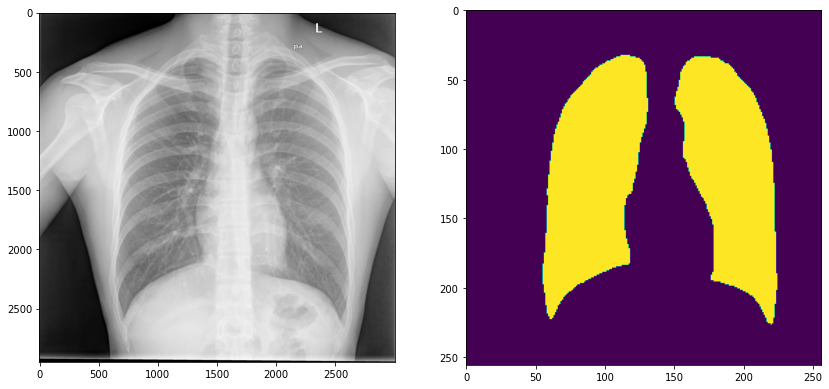

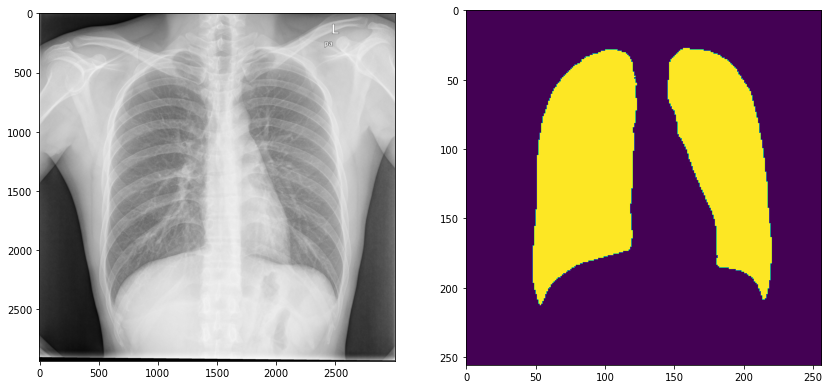

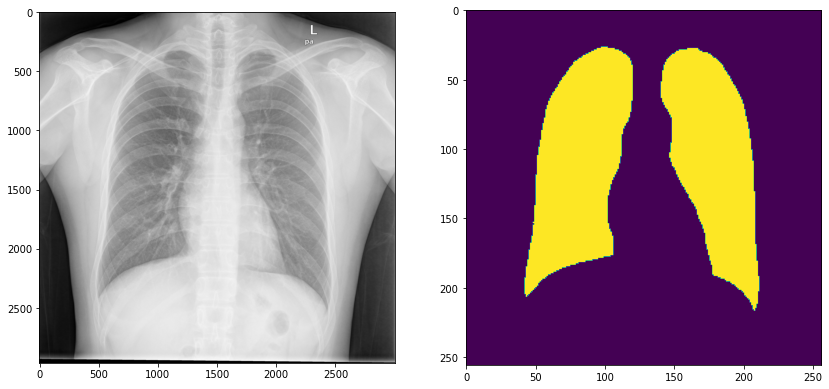

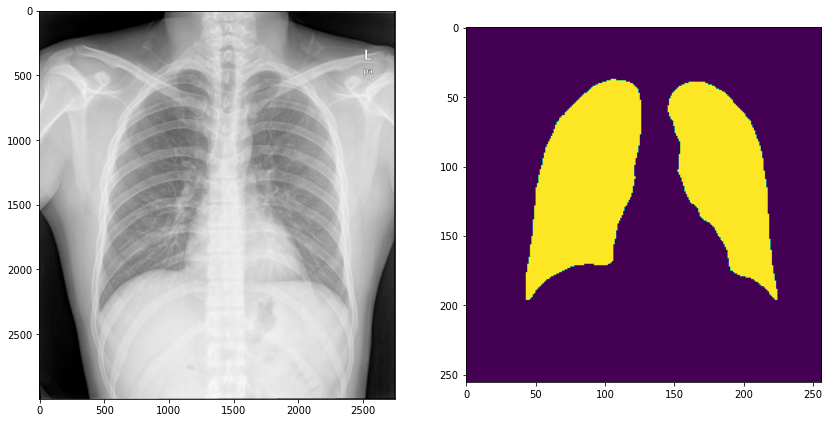

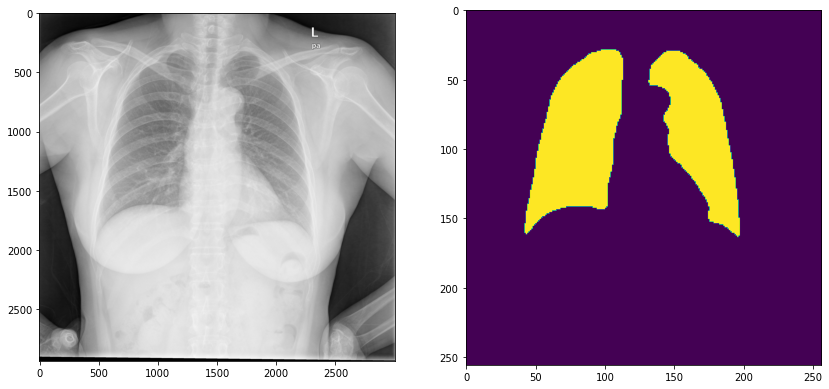

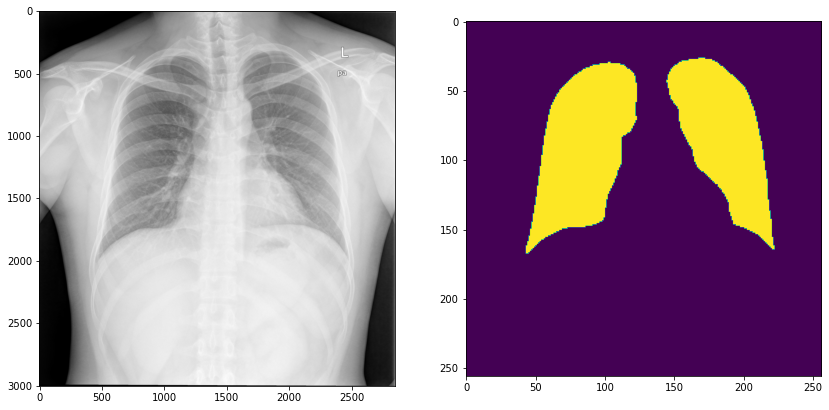

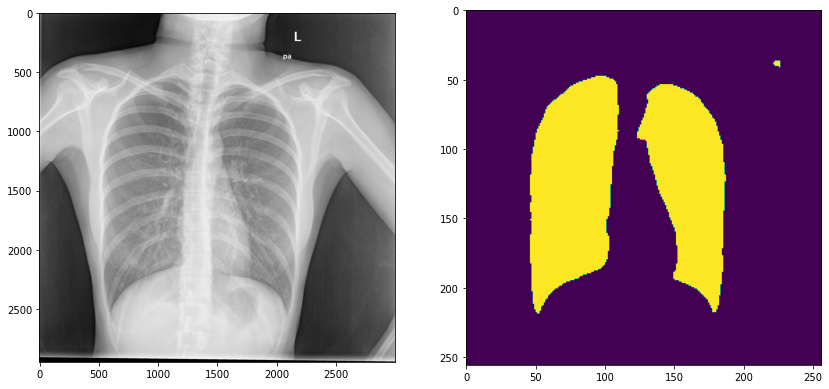

In [143]:
import matplotlib.pyplot as plt
get_results(test_ds, model)